box L = 3.405e-09 m, dt = 1.079e-14 s, tau = 2.158e-12 s
Saved 200 frames, total time = 2.148e-11 s
Wrote traj_scaled_for_vis.xyz


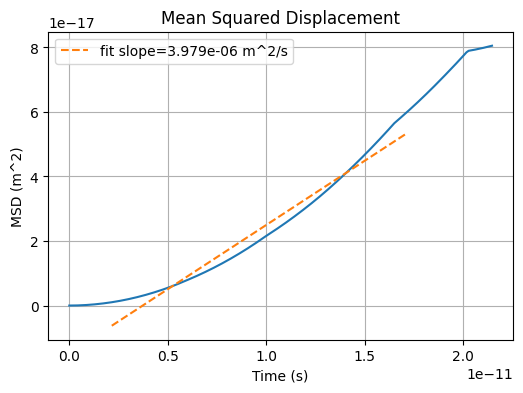

Estimated diffusion coefficient D = 6.631e-07 m^2/s


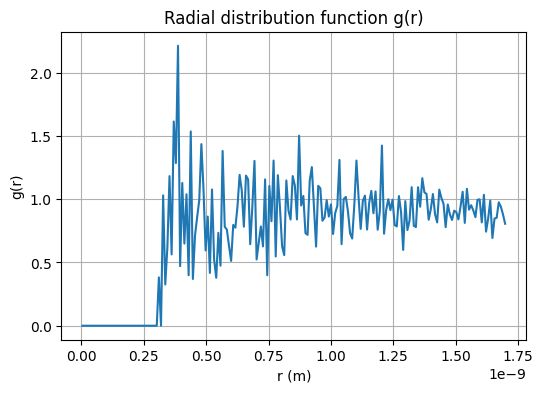

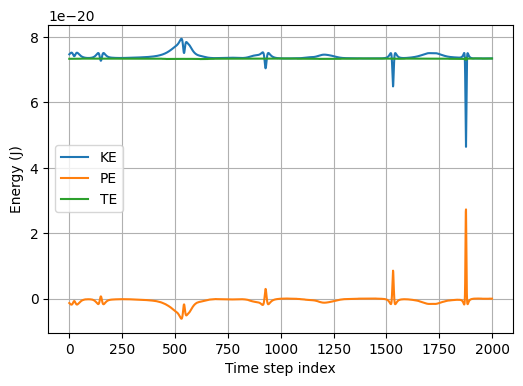

In [1]:
# ------------------------------
# MD with PBC, RDF, MSD & D
# Copy-paste into a Jupyter cell and run
# ------------------------------
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Physical / simulation params
# ------------------------------
# Argon constants (SI)
sigma   = 3.405e-10      # m
epsilon = 1.65e-21       # J
mass_atom = 6.63e-26     # kg

# Simulation choices
N = 10                   # number of particles
L = 10.0 * sigma         # box length (m) = 10 * sigma
rc = 2.5 * sigma         # cutoff (m)
rho = N / (L**3)         # number density

dt_star = 0.005          # reduced time step
tau = sigma * np.sqrt(mass_atom / epsilon)   # LJ time unit (s)
dt = dt_star * tau      # real timestep (s)

nsteps = 2000
save_stride = 10        # save every this many steps

print(f"box L = {L:.3e} m, dt = {dt:.3e} s, tau = {tau:.3e} s")

# ------------------------------
# LJ potential (dimensional)
# ------------------------------
def U_LJ(r, sigma, epsilon):
    sr = sigma / r
    sr6 = sr**6
    return 4 * epsilon * (sr6**2 - sr6)

def F_LJ(r, sigma, epsilon):
    sr = sigma / r
    sr6 = sr**6
    # magnitude of force
    return 24 * epsilon * (2 * sr6**2 - sr6) / r

# ------------------------------
# Minimum image and force calc
# ------------------------------
def minimum_image(vec, L):
    """Apply minimum image convention to vector(s). Works for single vector or array of vectors."""
    return vec - L * np.round(vec / L)

def compute_forces(positions, rc, sigma, epsilon, L):
    N = positions.shape[0]
    forces = np.zeros_like(positions)
    potential = 0.0
    for i in range(N - 1):
        for j in range(i + 1, N):
            rij = positions[i] - positions[j]
            rij = minimum_image(rij, L)           # wrap to nearest image
            r = np.linalg.norm(rij)
            if r < 1e-12:
                continue
            if r < rc:
                fij_mag = F_LJ(r, sigma, epsilon)
                fij_vec = fij_mag * (rij / r)
                forces[i] += fij_vec
                forces[j] -= fij_vec
                potential += U_LJ(r, sigma, epsilon)
    return forces, potential

# ------------------------------
# Initialize positions and velocities
# ------------------------------
np.random.seed(1)
positions = np.random.rand(N, 3) * L   # initial positions inside box (m)
velocities = np.random.randn(N, 3)     # unitless for now
velocities -= velocities.mean(axis=0)  # remove COM drift

# Scale velocities to a realistic temperature (optional)
kB = 1.380649e-23   # J/K
T = 120.0           # K (example)
v_rms_target = np.sqrt(3 * kB * T / mass_atom)
current_rms = np.sqrt(np.mean(velocities**2))
velocities *= v_rms_target / current_rms   # now velocities in m/s

# Prepare trajectory containers
traj_wrapped = []   # for writing scaled xyz (wrapped in box)
traj_unwrapped = [] # for MSD (unwrapped positions)
KE_list, PE_list, TE_list = [], [], []

# For unwrapped tracking: start equal to current positions
unwrapped = positions.copy()

# initial forces
forces, pot = compute_forces(positions, rc, sigma, epsilon, L)

# ------------------------------
# Main MD loop (Velocity-Verlet with PBC + unwrapping)
# ------------------------------
for step in range(nsteps):
    # half-step velocities
    velocities += 0.5 * (forces / mass_atom) * dt

    # old positions for unwrapping
    pos_old = positions.copy()

    # full-step positions (may be outside 0..L)
    positions += velocities * dt

    # compute image-corrected displacement and update unwrapped positions
    delta_raw = positions - pos_old
    delta_image = delta_raw - L * np.round(delta_raw / L)   # minimum-image displacement across boundary
    unwrapped += delta_image

    # now wrap positions back into [0, L)
    positions = positions % L

    # recompute forces at new (wrapped) positions
    forces, pot = compute_forces(positions, rc, sigma, epsilon, L)

    # finish velocity update
    velocities += 0.5 * (forces / mass_atom) * dt

    # energies
    kin = 0.5 * mass_atom * np.sum(velocities**2)
    KE_list.append(kin)
    PE_list.append(pot)
    TE_list.append(kin + pot)

    # save trajectory frames
    if step % save_stride == 0:
        traj_wrapped.append(positions.copy())
        traj_unwrapped.append(unwrapped.copy())

# convert lists to arrays
traj_wrapped = np.array(traj_wrapped)    # shape (nframes, N, 3)
traj_unwrapped = np.array(traj_unwrapped)
nframes = traj_wrapped.shape[0]
times = (np.arange(nframes) * save_stride) * dt

print(f"Saved {nframes} frames, total time = {times[-1]:.3e} s")

# ------------------------------
# Write scaled XYZ for visualization (scale meters -> angstroms)
# ------------------------------
scale = 1e10  # m -> Angstrom
with open("traj_scaled_for_vis.xyz", "w") as f:
    for k, frame in enumerate(traj_wrapped):
        f.write(f"{N}\nFrame {k}\n")
        for atom in frame:
            x, y, z = atom * scale
            f.write(f"Ar {x:.6f} {y:.6f} {z:.6f}\n")
print("Wrote traj_scaled_for_vis.xyz")

# ------------------------------
# Radial distribution function g(r)
# ------------------------------
# Collect pair distances (minimum image) over all frames
r_max = L / 2.0
nbins = 200
bins = np.linspace(0.0, r_max, nbins + 1)
hist = np.zeros(nbins)

for frame in traj_wrapped:
    # compute pair distances (i<j)
    for i in range(N - 1):
        rij_all = frame[i] - frame[i+1:]          # shape (N-i-1, 3)
        rij_all = minimum_image(rij_all, L)
        dists = np.linalg.norm(rij_all, axis=1)
        # bin distances
        counts, _ = np.histogram(dists, bins=bins)
        hist += counts

# normalization
r = 0.5 * (bins[:-1] + bins[1:])
dr = bins[1] - bins[0]
num_frames = nframes
# total pairs per frame = N*(N-1)/2
pair_count_per_frame = N * (N - 1) / 2.0
# number density
rho = N / (L**3)
# g(r) normalization:
# average neighbors per particle in shell = (2 * hist_total) / (num_frames * N)
# g(r) = average_neighbors / (4 * pi * r^2 * dr * rho)
g_r = np.zeros_like(r)
for idx, rval in enumerate(r):
    shell_vol_density = 4.0 * np.pi * rval**2 * dr * rho
    avg_neighbors = (2.0 * hist[idx]) / (num_frames * N)
    g_r[idx] = avg_neighbors / shell_vol_density

# ------------------------------
# Mean Squared Displacement (MSD) and Diffusivity
# ------------------------------
msd = []
for frame in traj_unwrapped:
    displacements = frame - traj_unwrapped[0]    # displacement from t0 (unwrapped)
    sq_disp = np.sum(displacements**2, axis=1)   # per-particle squared displacement
    msd.append(np.mean(sq_disp))                 # average over particles
msd = np.array(msd)

# Fit slope to MSD(t) to get D from MSD = 6 D t
# Fit only the linear region: avoid very short times (ballistic) and very late times (noise)
# We'll fit between 10% and 80% of the time range as a robust choice.
i0 = max(1, int(0.10 * len(times)))
i1 = max(i0+2, int(0.80 * len(times)))
coeffs = np.polyfit(times[i0:i1], msd[i0:i1], 1)  # linear fit
slope = coeffs[0]
D = slope / 6.0

# ------------------------------
# Plots
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(times, msd)
plt.plot(times[i0:i1], np.polyval(coeffs, times[i0:i1]), '--', label=f'fit slope={slope:.3e} m^2/s')
plt.xlabel('Time (s)')
plt.ylabel('MSD (m^2)')
plt.title('Mean Squared Displacement')
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated diffusion coefficient D = {D:.3e} m^2/s")

plt.figure(figsize=(6,4))
plt.plot(r, g_r)
plt.xlabel('r (m)')
plt.ylabel('g(r)')
plt.title('Radial distribution function g(r)')
plt.grid(True)
plt.show()

# Also plot energies quickly
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(KE_list)), KE_list, label='KE')
plt.plot(np.arange(len(PE_list)), PE_list, label='PE')
plt.plot(np.arange(len(TE_list)), TE_list, label='TE')
plt.xlabel('Time step index')
plt.ylabel('Energy (J)')
plt.legend()
plt.grid(True)
plt.show()
